# 08 Plot Figure S1 #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import numpy as np
from dask.distributed import Client
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import load_data, ext_freq
from cdrmip_extremes.plotting import plot_extremes

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load piControl extreme frequency data ##

In [3]:
ext_freq_data = load_data.load_ext_freq_piControl()

In [4]:
heat_freq = {
    model: ds_dict['heat_exceedances'] for model, ds_dict in ext_freq_data.items()
}
cold_freq = {
    model: ds_dict['cold_exceedances'] for model, ds_dict in ext_freq_data.items()
}

## Plot multi-model median ##

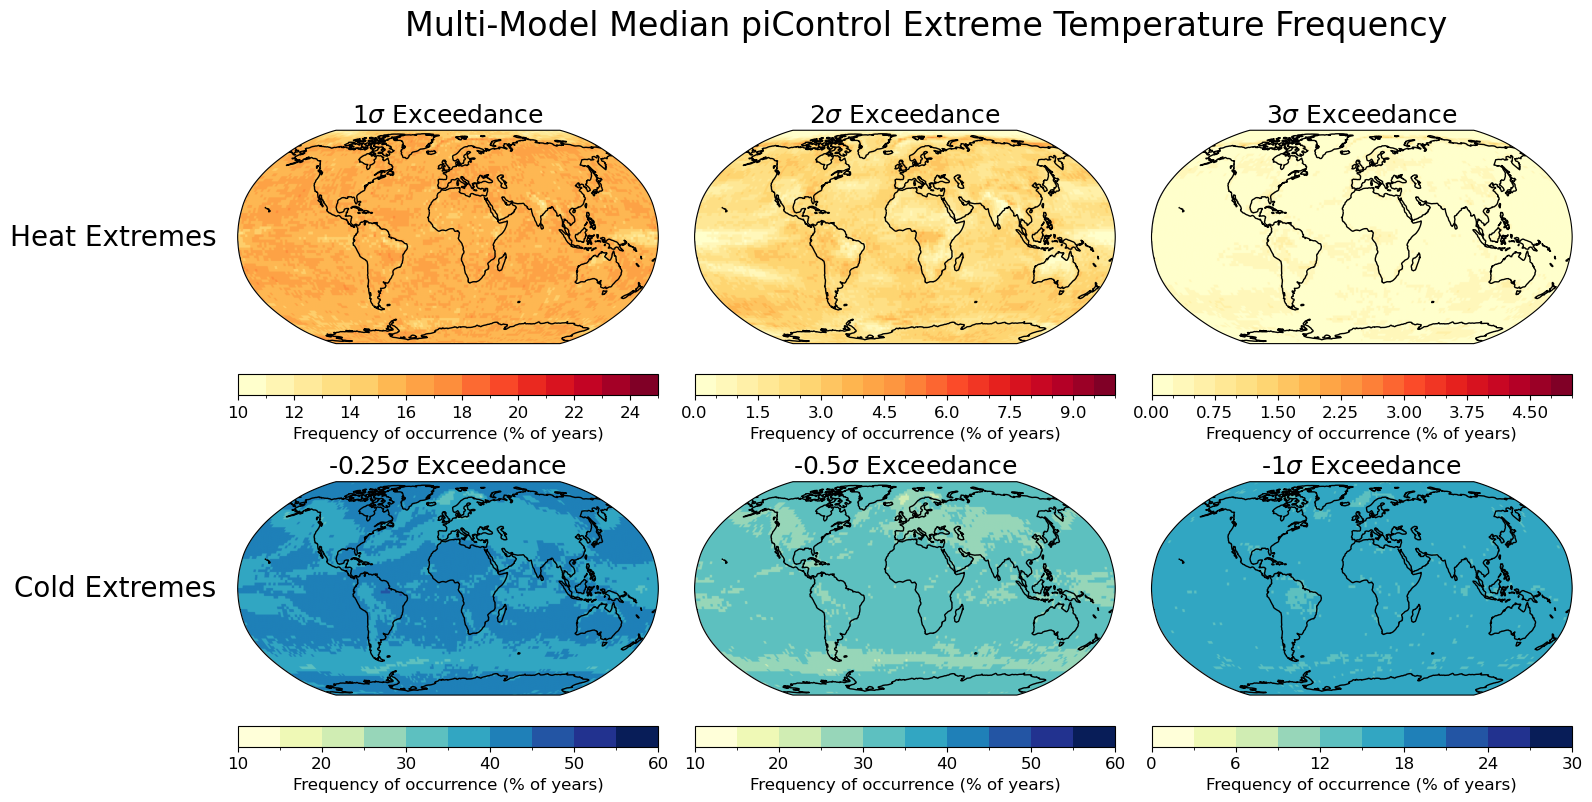

In [5]:
# define symbols for threhsolds for title
heat_symbs = {'sigma1':'1$\sigma$',
              'sigma2':'2$\sigma$',
              'sigma3':'3$\sigma$'
            }
cold_symbs = {'sigma1':'-0.25$\sigma$',
              'sigma2':'-0.5$\sigma$',
              'sigma3':'-1$\sigma$'
            }
thresholds = ['sigma1','sigma2','sigma3']
to_plot = {
    'heat':{
        threshold: heat_freq['Multi-Model Median'][threshold] for threshold in thresholds
    },
    'cold':{
        threshold: cold_freq['Multi-Model Median'][threshold] for threshold in thresholds
    },       
}

levels_dict = {
    'heat': {
        'sigma1':BoundaryNorm(np.linspace(10,25,16), ncolors=plt.cm.YlOrRd.N, clip=True),
        'sigma2':BoundaryNorm(np.linspace(0,10,21), ncolors=plt.cm.YlOrRd.N, clip=True),
        'sigma3':BoundaryNorm(np.linspace(0,5,21), ncolors=plt.cm.YlOrRd.N, clip=True),
    },
    'cold': {
        'sigma1':BoundaryNorm(np.linspace(10,60,11), ncolors=plt.cm.YlOrRd.N, clip=True),
        'sigma2':BoundaryNorm(np.linspace(10,60,11), ncolors=plt.cm.YlOrRd.N, clip=True),
        'sigma3':BoundaryNorm(np.linspace(0,30,11), ncolors=plt.cm.YlOrRd.N, clip=True),
    }
}   

fig, axes = plt.subplots(2,3, subplot_kw={"projection":ccrs.Robinson()},
                     figsize=(16,8),
                     sharey=True,)

cbar_kwargs = {"fraction": 0.08, "aspect": 20,
                "label":"% Years",'orientation':'horizontal',
                'location':'bottom','pad':0.04,
              'anchor':(0.5,-4), #'extend':'both'
              }

for row_index, ext_type in enumerate(to_plot.keys()):
    if ext_type == 'heat':
        cmap='YlOrRd'
        threshold_symbs=heat_symbs
        levels = levels_dict['heat']
    else:
        cmap='YlGnBu'
        threshold_symbs=cold_symbs
        levels = levels_dict['cold']
        
    for col_index, threshold in enumerate(to_plot[ext_type].keys()):
        ax = axes[row_index,col_index]
        im = ax.imshow(to_plot[ext_type][threshold],
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       origin='lower',
                       extent=(0,360,-90,90),
                       norm=levels[threshold]
                      )
        ax.coastlines()
        ax.set_title(f"{threshold_symbs[threshold]} Exceedance",fontsize=18)
        
        cbar = fig.colorbar(im, ax=ax, **cbar_kwargs)
        cbar.set_label("Frequency of occurrence (% of years)", fontsize=12)
        cbar.ax.tick_params(labelsize=12)

axes[0][0].annotate('Heat Extremes',
                    xy = (-0.05,0.5),
                    xycoords="axes fraction",
                    ha='right',
                    va='center',
                    fontsize=20,
                    rotation=0
                   )
axes[1][0].annotate('Cold Extremes',
                    xy = (-0.05,0.5),
                    xycoords="axes fraction",
                    ha='right',
                    va='center',
                    fontsize=20,
                    rotation=0
                   )

fig.suptitle(f"Multi-Model Median piControl Extreme Temperature Frequency",
             fontsize=24,x=0.58,
             y=1.0
            )
fig.tight_layout()
plt.show()